# DWS 2022 - Dataset building

## Importação de Bibliotecas Python

In [13]:
try:
    import textblob
except:
    !pip install textblob
    import textblob
from textblob import TextBlob

try:
    import wordcloud
except:
    !pip install wordcloud
    import wordcloud
from wordcloud import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import *
from sklearn.decomposition import *



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thalisson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/thalisson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Leitura da planilha original e remoção de dados pessoais

In [14]:
#original_data = pd.read_excel('DSW2022_OriginalData.xlsx')
#data_frame = original_data.copy(deep=True)
#df_no_personal_data = data_frame.copy(deep=True)
#df_no_personal_data.drop([
#                    'Carimbo de data/hora','E-mail',
#                    'Sinta-se a vontade para fazer comentários sobre as declarações acima, se desejar.'
#                    ]
#                    , inplace=True, axis=1)
#df_no_personal_data.to_csv('DSW2022_PublicData.csv', index=True)

## Leitura da planilha pública dos dados

In [26]:
df = pd.read_csv('DSW2022_PublicData.csv')
data = df.copy(deep=True)
len(data)

267

## Remoção dos dados inválidos

In [27]:
df_disagree = data.loc[data['Para começar, confirme sua autorização selecionando uma das opções abaixo:'] == 'Confirmo que li, concordo com os termos e aceito participar.']
len(df_disagree)

264

In [28]:
df_no_interest = df_disagree.loc[(df_disagree['Em relação a temas como Usabilidade, Experiência do Usuário (UX), Interação Humano-Computador, Design Centrado no Usuário e outros, você se considera'] != 'Pouco interessado nesses temas') & (df_disagree['Em relação a temas como Usabilidade, Experiência do Usuário (UX), Interação Humano-Computador, Design Centrado no Usuário e outros, você se considera'] != 'Não sou interessado nesses temas') & (df_disagree['Dentre essas definições, qual você escolheria'].notnull())]
len(df_no_interest)

253

In [29]:
df_no_interest.to_csv('UXData-BR.csv', index=True)
df_no_interest

,Unnamed: 0,"Para começar, confirme sua autorização selecionando uma das opções abaixo:","Em relação a temas como Usabilidade, Experiência do Usuário (UX), Interação Humano-Computador, Design Centrado no Usuário e outros, você se considera",A UX é muito dinâmica - muda constantemente enquanto há interação com um produto. [Marque uma opção. ],A expectativa de uso de um produto pode resultar em experiências reais. [Marque uma opção. ],"Aspectos efêmeros e estáveis do estado interno de uma pessoa (por exemplo: necessidades, motivações) afetam a experiência da pessoa com algo. [Marque uma opção. ]",A UX é melhor compreendida se analisada dentro da área de marketing. [Marque uma opção. ],UX ocorre e depende do contexto em que o artefato é experimentado. [Marque uma opção. ],"UX não é sobre o desempenho do usuário (habilidade para entender e utilizar) em relação a um artefato, mas sobre a percepção pessoal dele sobre esse desempenho. [Marque uma opção. ]",Definitivamente existe a necessidade de uma definição padronizada para o termo UX. [Marque uma opção. ],...,Em qual cidade você vive?,Região,Você é,Role,Domain,Sua formação principal foi na área de,Educação,Você já atuou ou atua profissionalmente com UX?,"Complete a frase: ""Eu estou interessado(a) em entender o conceito de UX...""","Atualmente, quão importante é a UX para a sua vida profissional/acadêmica?"
0,0,"Confirmo que li, concordo com os termos e acei...",Muito interessado em pelo menos um dos temas,Concordo parcialmente,Concordo parcialmente,Concordo totalmente,Discordo parcialmente,Concordo totalmente,Concordo parcialmente,Concordo totalmente,...,São Paulo,Sudeste,Analista,Profissional,Mercado,Comunicação,Outros,"Sim, como contratado.","""... para deixar os usuários satisfeitos""",7.0
1,1,"Confirmo que li, concordo com os termos e acei...",Muito interessado em pelo menos um dos temas,Concordo parcialmente,Não entendi a frase.,Concordo totalmente,Discordo parcialmente,Concordo totalmente,Discordo totalmente,Concordo parcialmente,...,João Pessoa,Nordeste,Analista de UX,Profissional,Mercado,Computação e/ou tecnologia,Tecnologia / Computação / IHC,"Sim, na empresa na qual trabalho","""... para criar produtos melhores""",7.0
2,2,"Confirmo que li, concordo com os termos e acei...",Muito interessado em pelo menos um dos temas,Concordo totalmente,Concordo totalmente,Concordo totalmente,Discordo totalmente,Concordo totalmente,Concordo totalmente,Discordo parcialmente,...,Fortaleza,Nordeste,Desenvolvedor,Profissional,Mercado,Computação e/ou tecnologia,Tecnologia / Computação / IHC,"Sim, como contratado.","""... para criar produtos melhores"", ""... para ...",7.0
3,3,"Confirmo que li, concordo com os termos e acei...",Muito interessado em pelo menos um dos temas,Concordo totalmente,Concordo parcialmente,Concordo totalmente,Discordo parcialmente,Concordo totalmente,Concordo parcialmente,Concordo parcialmente,...,São Carlos,Sudeste,Designer,Profissional,Mercado,Design,Design,"Sim, como contratado.",Para ser mais assertivono uso e rotina da prof...,7.0
4,4,"Confirmo que li, concordo com os termos e acei...",Muito interessado em pelo menos um dos temas,Concordo totalmente,Concordo totalmente,Concordo totalmente,Discordo totalmente,Concordo totalmente,Discordo parcialmente,Concordo totalmente,...,Brasília,Centro-oeste,Designer,Profissional,Mercado,Design,Design,"Sim, como contratado., Sim, como freelancer ou...","""... para criar produtos melhores""",7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,"Confirmo que li, concordo com os termos e acei...",Muito interessado em pelo menos um dos temas,Concordo totalmente,Concordo totalmente,Não entendi a frase.,Concordo totalmente,Indiferente,Concordo parcialmente,Concordo parcialmente,...,Belfast,Fora do Brasil,Estudante,Estudante,Mercado,Ciencias da Informaçao,Tecnologia / Computação / IHC,Não.,Ja sou da area dE pesquisa,7.0
262,262,"Confirmo que li, concordo com os termos e acei...",Interessa

## Análise Preliminar Automatizada dos dados

In [30]:
#adaptado de https://dadosaocubo.com/nlp-com-scikit-learn/ e https://medium.com/analytics-vidhya/topic-modelling-using-lda-aa11ec9bec13
stop_words = stopwords.words('portuguese')
stop_words.append('que')
stop_words.append('Pq')
stop_words.append('A')
stop_words.append('onde')
stop_words.append('Porque')
stop_words.append('É')
stop_words.append('D')
stop_words

def _get_avg_word_len(x):
    words = x.split()
    word_len = 0
    if len(words) > 0:
        for word in words:
            word_len = word_len + len(word)
        return word_len/len(words)
    else:
        return 0
def feature_extract(df,d):
    df['count']=df[d].apply(lambda x: len(str(x).split()))
    df['char count']=df[d].apply(lambda x: len(x))
    df['avg word_len'] = df[d].apply(lambda x:_get_avg_word_len(x))
    df['stop_words_len'] = df[d].apply(lambda x: len([t for t in x.split() if t in stop_words]))
    df['numeric_count'] = df[d].apply(lambda x:len([t for t in x.split()if t.isdigit()] ))
    df['upper_counts'] = df[d].apply(lambda x: len([t for t in x.split() if t.isupper() and len(x)>3]))
    df['polarity'] = df[d].map(lambda text: TextBlob(text).sentiment.polarity)

In [31]:
selected_columns = df_no_interest[['Justificativa']]
df = selected_columns.copy()
df['Nova_Justificativa'] = df['Justificativa']
df = df.dropna()
df

,Justificativa,Nova_Justificativa
0,Acredito que qualquer tipo de interação do usu...,Acredito que qualquer tipo de interação do usu...
1,Todas as definições trazem aspectos importante...,Todas as definições trazem aspectos importante...
2,(Vide resposta aberta na seção anterior),(Vide resposta aberta na seção anterior)
3,Acredito que essa seja a mais generalista e ab...,Acredito que essa seja a mais generalista e ab...
4,Menciona os aspectos que julgo necessários par...,Menciona os aspectos que julgo necessários par...
...,...,...
261,Pq ha limitacao da tarefa conforme dispositivo,Pq ha limitacao da tarefa conforme dispositivo
262,Pq Concordo com a afirmação,Pq Concordo com a afirmação
264,Foi a que pareceu mais completa sem significar...,Foi a que pareceu mais completa sem significar...
265,Achei a definição mais abrangente,Achei a definição mais abrangente


In [32]:
col = 'Nova_Justificativa'

df[col] = df[col].str.replace('[,.:;!?]+', ' ', regex=True).copy()
df[col] = df[col].str.replace ('[/<>()|\+\-\$%&#@\'\"]+', ' ', regex=True).copy()
df[col] = df[col].str.replace('[0-9]+', '', regex=True).copy()
df[col] = df[col].apply(lambda x: " ".join([t for t in x.split() if t not in stop_words]))
df[col]

0      Acredito qualquer tipo interação usuário produ...
1      Todas definições trazem aspectos importantes O...
2                    Vide resposta aberta seção anterior
3      Acredito generalista abrangente todas contempl...
4      Menciona aspectos julgo necessários descrever ...
                             ...                        
261             ha limitacao tarefa conforme dispositivo
262                                   Concordo afirmação
264              Foi pareceu completa significar UX tudo
265                           Achei definição abrangente
266    Muito parte dito verdadeira experiência usuári...
Name: Nova_Justificativa, Length: 253, dtype: object

In [33]:
#avg_word_len = get_avg_word_len(feat)
#avg_word_len
feature_extract(df, 'Justificativa')
df

,Justificativa,Nova_Justificativa,count,char count,avg word_len,stop_words_len,numeric_count,upper_counts,polarity
0,Acredito que qualquer tipo de interação do usu...,Acredito qualquer tipo interação usuário produ...,18,114,5.388889,6,0,0,0.0
1,Todas as definições trazem aspectos importante...,Todas definições trazem aspectos importantes O...,33,204,5.212121,14,0,1,0.0
2,(Vide resposta aberta na seção anterior),Vide resposta aberta seção anterior,6,40,5.833333,1,0,0,0.0
3,Acredito que essa seja a mais generalista e ab...,Acredito generalista abrangente todas contempl...,32,178,4.593750,16,0,0,0.0
4,Menciona os aspectos que julgo necessários par...,Menciona aspectos julgo necessários descrever ...,10,74,6.500000,4,0,0,0.0
...,...,...,...,...,...,...,...,...,...
261,Pq ha limitacao da tarefa conforme dispositivo,ha limitacao tarefa conforme dispositivo,7,47,5.714286,2,0,0,0.0
262,Pq Concordo com a afirmação,Concordo afirmação,5,27,4.600000,3,0,0,0.0
264,Foi a que pareceu mais completa sem significar...,Foi pareceu completa significar UX tudo,11,58,4.363636,5,0,1,0.0
265,Achei a definição mais abrangente,Achei definição abrangente,5,33,5.800000,2,0,0,0.0


In [34]:
cv = CountVectorizer(strip_accents='ascii', 
                      lowercase=True)
text_counts = cv.fit_transform(df['Nova_Justificativa'])
cv_df = pd.DataFrame(text_counts.toarray(), columns = cv.get_feature_names_out())
cv_df

,abaixo,aberta,aberto,aborda,abordagem,abordagens,abordando,abordou,abrange,abrangendo,...,vital,vive,vivem,vivemos,vivencia,vivenciada,vividas,volta,with,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


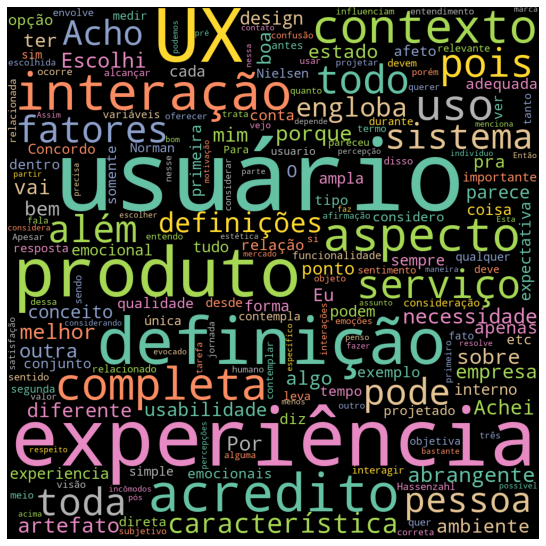

In [36]:
text = ' '.join(df['Nova_Justificativa'].values)
fig = plt.figure(figsize=(90,45))
ax = fig.add_subplot(4,3,1)
wc = WordCloud(width=1000, 
               height=1000, 
               random_state=1, 
               background_color='Black',
               colormap='Set2',
               collocations=False).generate(text)
ax.imshow(wc)
ax.axis("off");